In [10]:
import os
import time
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
from rapidfuzz import fuzz, process
from collections import Counter

# Initial API Call

Before diving into model building with a large data set, we will make an initial API call to fetch some data for 100 games. To prevent further unnecassary API calls, we'll save this as a csv.

We'll use this small dataset to determine a suitable proxy target (by analysing potential candidate targets for game success), as well as exploring the potential feature space by using NLP techniques to extract embeddings from text data such as raw descriptions, tags and genres. All this will allow us to define a suitable feature set X and target y (with the associated preprocessing to get them).

We'll then be able to make a further API call to extract a larger data set, apply appropriate preprocessing and start model development.

In [ ]:
load_dotenv()
API_KEY = os.getenv('RAWG_API_KEY')
BASE_URL = 'https://api.rawg.io/api'

def get_details(game_id: int):
    url = f'{BASE_URL}/games/{game_id}'
    params = {'key': API_KEY}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    return None

def get_games(num_games: int, delay=1.0) -> pd.DataFrame:
    all_games = []
    default_page_size = 40
    num_pages = (num_games + default_page_size - 1) // default_page_size

    for page in range(1, num_pages+1):
        remaining = num_games - len(all_games)
        page_size = min(default_page_size, remaining)
        print(f'Fetching list page {page} with page_size={page_size}...')
        
        url = f'{BASE_URL}/games'
        params = {
            'key': API_KEY,
            'page_size': page_size,
            'page': page,
            'ordering': '-added'
        }

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f'Error {response.status_code} on page {page}')
            break

        games = response.json().get('results', [])
        for game in games:
            print(f'Fetching details for: {game["name"]} (ID: {game["id"]})')
            details = get_details(game['id'])
            if details:
                all_games.append({
                    'id': details.get('id'),
                    'name': details.get('name'),
                    'released': details.get('released'),
                    'rating': details.get('rating'),
                    'playtime': details.get('playtime'),
                    'ratings_count': details.get('ratings_count'),
                    'added': details.get('added'),
                    'genres': [g['name'] for g in details.get('genres')],
                    'tags': [t['name'] for t in details.get('tags', [])],
                    'description_raw': details.get('description_raw', '')
                })
                time.sleep(delay)
        
        if len(all_games) >= num_games:
            break
    
    return pd.DataFrame(all_games)

def save_to_csv(df: pd.DataFrame, filename: str) -> None:
    df.to_csv(filename+'.csv', index=False)
    print(f'Saved {len(df)} games to {filename}.csv')

In [ ]:
# uncommenting the below starts an API call

'''

if __name__ == '__main__':
    df = get_games(num_games=_)
    save_to_csv(df, 'small_dataset')

'''

Fetching list page 1...
Fetching details for: Grand Theft Auto V (ID: 3498)
Fetching details for: The Witcher 3: Wild Hunt (ID: 3328)
Fetching details for: Portal 2 (ID: 4200)
Fetching details for: Counter-Strike: Global Offensive (ID: 4291)
Fetching details for: Tomb Raider (2013) (ID: 5286)
Fetching details for: Portal (ID: 13536)
Fetching details for: Left 4 Dead 2 (ID: 12020)
Fetching details for: The Elder Scrolls V: Skyrim (ID: 5679)
Fetching details for: Red Dead Redemption 2 (ID: 28)
Fetching details for: BioShock Infinite (ID: 4062)
Fetching details for: Half-Life 2 (ID: 13537)
Fetching details for: Borderlands 2 (ID: 802)
Fetching details for: Life is Strange (ID: 3439)
Fetching details for: BioShock (ID: 4286)
Fetching details for: Destiny 2 (ID: 32)
Fetching details for: God of War (2018) (ID: 58175)
Fetching details for: Fallout 4 (ID: 3070)
Fetching details for: PAYDAY 2 (ID: 3939)
Fetching details for: Limbo (ID: 1030)
Fetching details for: Team Fortress 2 (ID: 11859)
Fe

In [16]:
df

,id,name,released,rating,playtime,ratings_count,added,genres,tags,description_raw
0,3498,Grand Theft Auto V,2013-09-17,4.47,74,7141,22102,[Action],"[Singleplayer, Steam Achievements, Multiplayer...","Rockstar Games went bigger, since their previo..."
1,3328,The Witcher 3: Wild Hunt,2015-05-18,4.64,43,6943,21750,"[Action, RPG]","[Singleplayer, Full controller support, Atmosp...","The third game in a series, it holds nothing b..."
2,4200,Portal 2,2011-04-18,4.59,11,5930,20602,"[Shooter, Puzzle]","[Singleplayer, Steam Achievements, Multiplayer...",Portal 2 is a first-person puzzle game develop...
3,4291,Counter-Strike: Global Offensive,2012-08-21,3.57,64,3584,18279,[Shooter],"[Steam Achievements, Multiplayer, Full control...",Counter-Strike is a multiplayer phenomenon in ...
4,5286,Tomb Raider (2013),2013-03-05,4.06,10,4011,17613,[Action],"[Singleplayer, Multiplayer, Full controller su...",A cinematic revival of the series in its actio...
...,...,...,...,...,...,...,...,...,...,...
95,4161,Far Cry 3,2012-11-28,4.25,16,2921,10637,"[Action, Shooter]","[Singleplayer, Multiplayer, Atmospheric, RPG, ...",Far Cry 3 is absolute madness. Being the third...
96,10533,Path of Exile,2013-10-23,3.65,6,1630,10597,"[Action, RPG, Massively Multiplayer, Indie]","[Singleplayer, Steam Achievements, Multiplayer...",Path of Exile is inspired by Diablo II and fol...
97,9721,Garry's Mod,2004-12-24,3.80,14,1590,10399,"[Action, Adventure, Simulation, Casual, Indie]","[Singleplayer, Steam Achievements, Multiplayer...",Garry's Mod or simply GMod is a source-engine ...
98,19487,Alan Wake,2010-05-14,4.09,5,2251,10389,"[Action, Shooter, Adventure]","[Singleplayer, Steam Achievements, Full contro...",Titular best-selling psychological thriller au...


# Exploratory Analysis of Numerical Data - Defining the Target (y)

Goal for this section: establish an appropriate target y. We want y to reflect the success of a game, and so should take into account aspects such as ratings, ratings count, added count and potentially playtime.

Rating is a solid indicator of audience satisfaction with a game - but only when scaled appropriately with how many people actually engaged in the rating process; so I suspect that ratings multiplied by some function of ratings count might work. Added count and ratings count both reflect audience numbers, so I expect these to scale similarly. Playtime will probably be the most volatile, since a game with the shortest playtime might not have the lowest rating - playtime is largely dependent on the kind of gaming experience delivered (is it an open-world RPG with a small but loyal fanbase or a quick puzzle game with thousands of clicks?).

In [ ]:
df = pd.read_csv('../data/initial_exploration_dataset.csv')

df

,id,name,released,rating,playtime,ratings_count,added,genres,tags,description_raw
0,3498,Grand Theft Auto V,2013-09-17,4.47,74,7141,22102,['Action'],"['Singleplayer', 'Steam Achievements', 'Multip...","Rockstar Games went bigger, since their previo..."
1,3328,The Witcher 3: Wild Hunt,2015-05-18,4.64,43,6943,21750,"['Action', 'RPG']","['Singleplayer', 'Full controller support', 'A...","The third game in a series, it holds nothing b..."
2,4200,Portal 2,2011-04-18,4.59,11,5930,20602,"['Shooter', 'Puzzle']","['Singleplayer', 'Steam Achievements', 'Multip...",Portal 2 is a first-person puzzle game develop...
3,4291,Counter-Strike: Global Offensive,2012-08-21,3.57,64,3584,18279,['Shooter'],"['Steam Achievements', 'Multiplayer', 'Full co...",Counter-Strike is a multiplayer phenomenon in ...
4,5286,Tomb Raider (2013),2013-03-05,4.06,10,4011,17613,['Action'],"['Singleplayer', 'Multiplayer', 'Full controll...",A cinematic revival of the series in its actio...
...,...,...,...,...,...,...,...,...,...,...
95,4161,Far Cry 3,2012-11-28,4.25,16,2921,10637,"['Action', 'Shooter']","['Singleplayer', 'Multiplayer', 'Atmospheric',...",Far Cry 3 is absolute madness. Being the third...
96,10533,Path of Exile,2013-10-23,3.65,6,1630,10597,"['Action', 'RPG', 'Massively Multiplayer', 'In...","['Singleplayer', 'Steam Achievements', 'Multip...",Path of Exile is inspired by Diablo II and fol...
97,9721,Garry's Mod,2004-12-24,3.80,14,1590,10399,"['Action', 'Adventure', 'Simulation', 'Casual'...","['Singleplayer', 'Steam Achievements', 'Multip...",Garry's Mod or simply GMod is a source-engine ...
98,19487,Alan Wake,2010-05-14,4.09,5,2251,10389,"['Action', 'Shooter', 'Adventure']","['Singleplayer', 'Steam Achievements', 'Full c...",Titular best-selling psychological thriller au...


In [101]:
df.dtypes

id                     int64
name                  object
released              object
rating               float64
playtime               int64
ratings_count          int64
added                  int64
genres                object
tags                  object
description_raw       object
genres_list           object
tags_list             object
tags_list_cleaned     object
dtype: object

In [22]:
df.describe()

,id,rating,playtime,ratings_count,added
count,100.00000,100.000000,100.000000,100.000000,100.000000
mean,12226.19000,4.057600,11.170000,2576.860000,12160.700000
std,29950.86733,0.374687,12.220247,1155.511903,2625.059663
min,28.00000,3.070000,1.000000,727.000000,9653.000000
25%,3317.75000,3.807500,4.000000,1962.250000,10399.000000
50%,5424.50000,4.095000,7.000000,2363.500000,11230.000000
75%,12469.25000,4.380000,13.000000,2921.000000,13032.000000
max,290856.00000,4.640000,74.000000,7141.000000,22102.000000


As predicted, playtime seems a bit of a wild card - the large gap between the upper quartile and max value suggest a skewed distribution.

Of all the distributions, rating appears the least skewed, and so the best contender for a reliable success score so far.

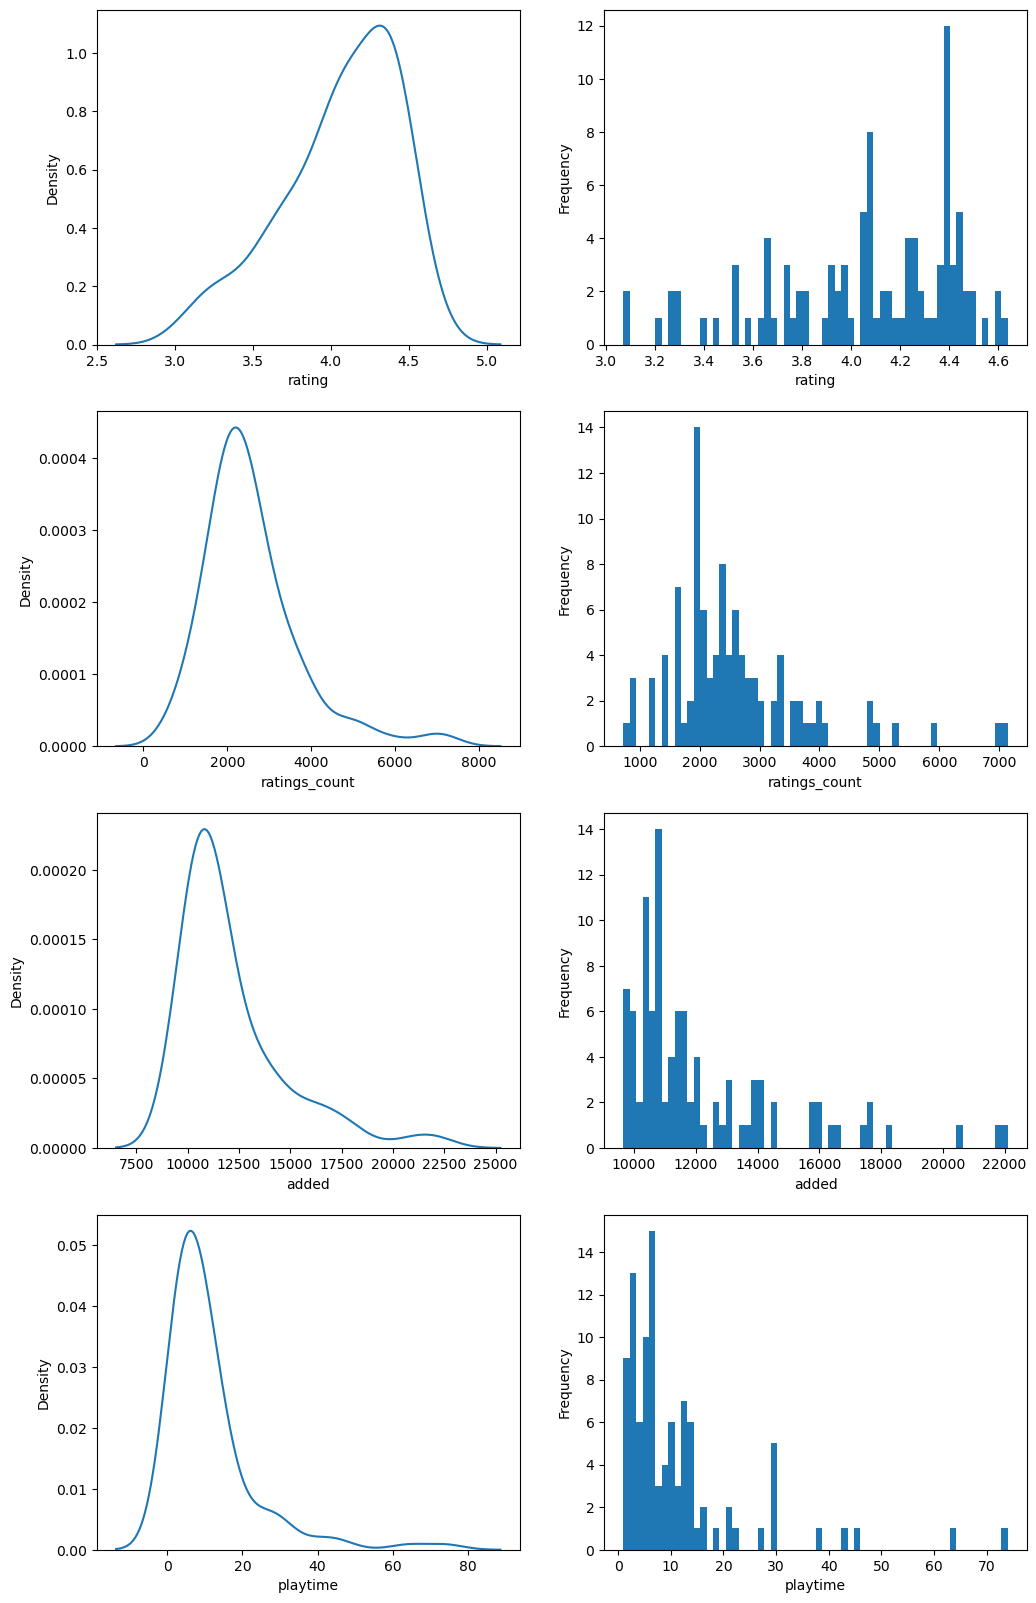

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,20))
for i, column in enumerate(['rating', 'ratings_count', 'added', 'playtime']):
    sns.kdeplot(df[column], ax=axes[i, 0])
    axes[i, 1].hist(df[column], bins=60)
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Frequency')
plt.show()

Again, playtime is clearly skewed - but mostly by outliers. If we did include playtime in our success score, we would either have to clip the outliers or go for quantile binning.


We will now have a look at how correlated each pair of these variables is, in order to suggest how they might be best combined in a success score. We'll print a covariance matrix first, and then explore the set of scatter plots for each pair of variables.

<Axes: >

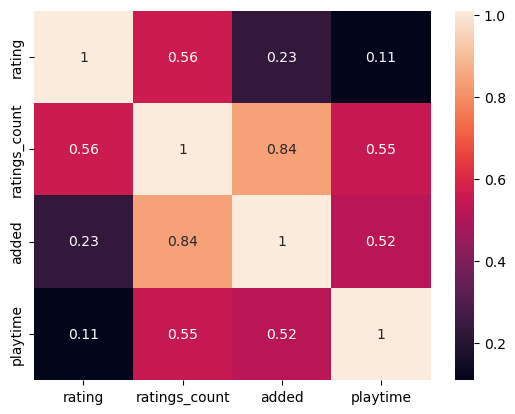

In [63]:
scaled_columns = scaler.fit_transform(df[cols])
covariance_matrix = pd.DataFrame(scaled_columns).cov()
covariance_matrix.columns, covariance_matrix.index = cols, cols
sns.heatmap(covariance_matrix, annot=True)

Playtime is poorly correlated with all other variables, especially ratings. Given this and its skew, it's probably a good idea to discard playtime from our possible success score.

As expected, ratings_count and added are highly correlated - once rescaled, it may be worth summing these as part of the success score.

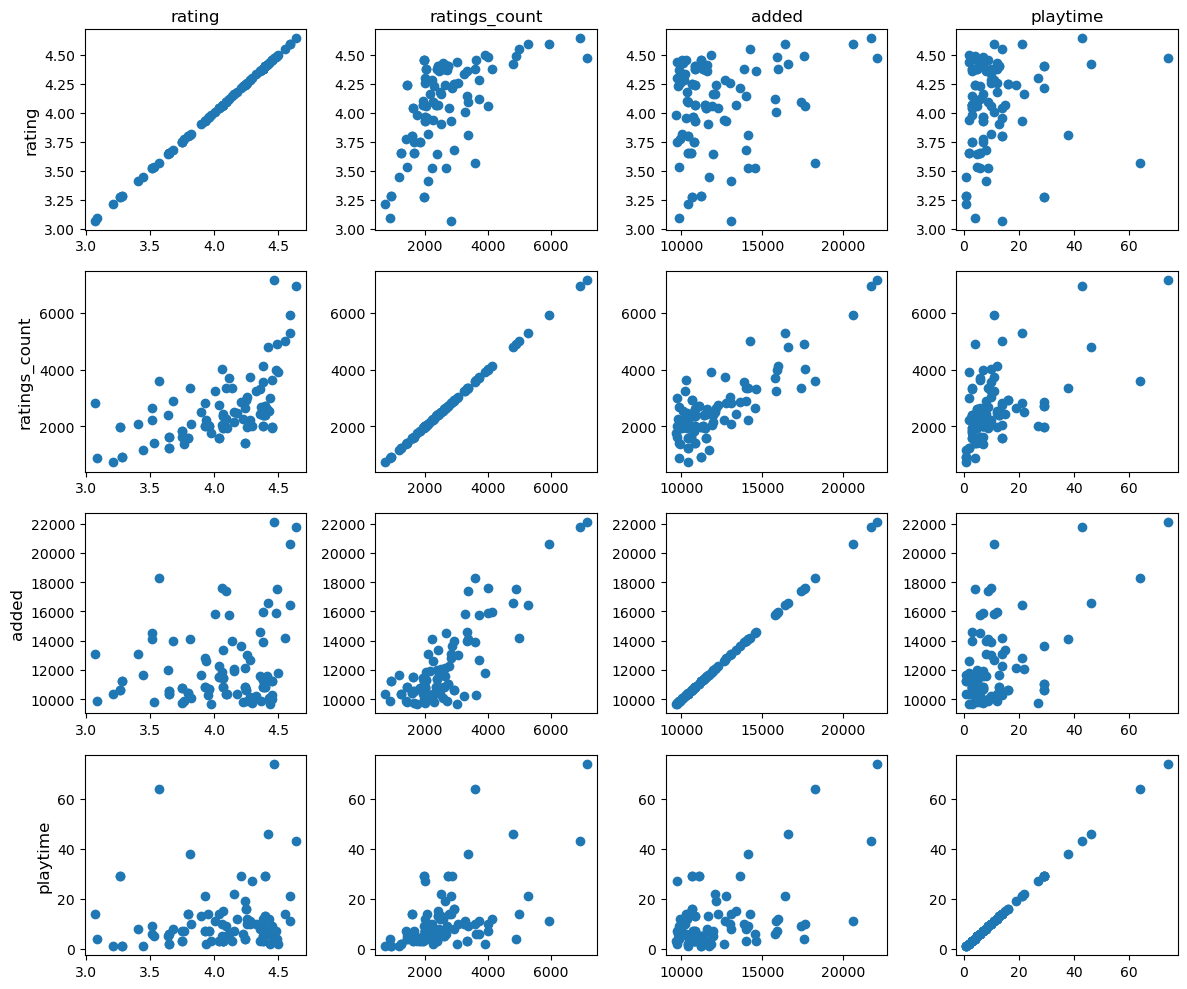

In [58]:
cols = ['rating', 'ratings_count', 'added', 'playtime']
rows = cols

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,10))

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axes[i, j]
        ax.scatter(df[col], df[row])

        if i == 0:
            ax.set_title(col)
        
        if j == 0:
            ax.set_ylabel(row, fontsize='large')

plt.tight_layout()

plt.show()

Given the clear linear correlation of ratings_count and added, we can confidently sum them as part of our success score.

Rating is inuitively the best indicator of game success (and the least skewed), but needs to be scaled based on the number of interactions with the game. We will scale by the logarithm of game interactions, in order to suppress any outliers that might affect rating in our larger dataset.

Our success score (aka the target y) will therefore be: success = rating * log(ratings_count + 0.25 * added)

Why not simply rating * log(ratings_count)? Rationale: this would omit popularity among gamers who don't rate the games they play - added is about 4x larger than ratings_count, so we would be ommitting signal from 3/4 of the population potentially playing the game.

In [4]:
scaler = StandardScaler()

success_raw = df['rating'] * np.log1p(df['ratings_count'] + 0.25 * df['added'])
success = scaler.fit_transform(success_raw.values.reshape(-1,1)).ravel()

success

array([ 1.89786937,  2.2877752 ,  2.0329449 , -0.72087241,  0.45944947,
        1.58417543,  0.43535522,  1.37420275,  1.83459621,  1.16872821,
        1.38144872,  0.18216319,  0.49942118,  0.95177335, -1.07658429,
        1.62847997, -0.32670608, -1.1592152 ,  0.42376164, -0.69524398,
        1.00915045,  0.48583152,  0.08356314, -2.12446635, -1.46629325,
        0.60728286, -0.18741336,  0.75489939, -0.27720548,  0.02396248,
        0.44752046,  0.24065964, -0.94999388,  0.16170335, -0.09039529,
        1.25602573, -1.62228225, -0.36014763,  0.65046562,  0.79697383,
       -0.248871  , -0.11013993,  0.67012743,  0.58474857, -2.07006291,
        0.72232222,  0.76745326,  0.09705062,  0.68709704, -0.0563644 ,
       -0.43871521,  0.68836845, -0.87429736, -0.38043891, -1.90488756,
        0.45216935, -1.14515425, -0.83999616, -0.0561018 , -1.25308773,
       -2.31279853,  0.19080616, -0.11151446,  1.02121598, -0.41505382,
        0.67100379,  0.33926731,  0.74553599, -0.70384445,  0.63

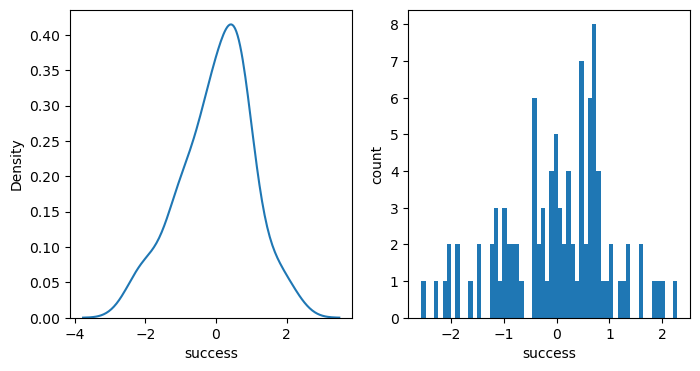

In [33]:
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.kdeplot(success)
plt.xlabel("success")
plt.subplot(1,2,2)
plt.hist(success, bins=60)
plt.xlabel("success")
plt.ylabel("count")
plt.show()

The distribution for success is now roughly normal - we'll have to check that it becoems even closer to normal with our larger dataset later.

# NLP - Extracting Features (X) from Text

The inputs for our ML models will be features extracted from a combination of the raw game description, tags and genres.

To start with, let's explore the raw description.

In [2]:
df.iloc[0,-1]

'Rockstar Games went bigger, since their previous installment of the series. You get the complicated and realistic world-building from Liberty City of GTA4 in the setting of lively and diverse Los Santos, from an old fan favorite GTA San Andreas. 561 different vehicles (including every transport you can operate) and the amount is rising with every update. \nSimultaneous storytelling from three unique perspectives: \nFollow Michael, ex-criminal living his life of leisure away from the past, Franklin, a kid that seeks the better future, and Trevor, the exact past Michael is trying to run away from. \nGTA Online will provide a lot of additional challenge even for the experienced players, coming fresh from the story mode. Now you will have other players around that can help you just as likely as ruin your mission. Every GTA mechanic up to date can be experienced by players through the unique customizable character, and community content paired with the leveling system tends to keep everyon

This description ends up switching to Spanish! We only want to work with text in one language (to keep the data pre-processing stage relatively simple), so let's cut out any non-English text.

Other languages are typically preceeded by the name of language on RAWG, so we'll simply cut out all text from and including the language name.

In [ ]:
def extract_english(text):
    match = re.search(r'\n(?:Español|Deutsch|Français|Русский|中文|日本語|한국어)\b', text)
    if match:
        return text[:match.start()].strip()
    return text

In [ ]:
example = extract_english(df.iloc[0,-1])
example

'Rockstar Games went bigger, since their previous installment of the series. You get the complicated and realistic world-building from Liberty City of GTA4 in the setting of lively and diverse Los Santos, from an old fan favorite GTA San Andreas. 561 different vehicles (including every transport you can operate) and the amount is rising with every update. \nSimultaneous storytelling from three unique perspectives: \nFollow Michael, ex-criminal living his life of leisure away from the past, Franklin, a kid that seeks the better future, and Trevor, the exact past Michael is trying to run away from. \nGTA Online will provide a lot of additional challenge even for the experienced players, coming fresh from the story mode. Now you will have other players around that can help you just as likely as ruin your mission. Every GTA mechanic up to date can be experienced by players through the unique customizable character, and community content paired with the leveling system tends to keep everyon

Now knowing this works, we can start actually extracting features from the text.

We will go for an embedding approach using nltk.

Nouns and adjectives seem most natural for characterising a game, so we'll stick to those - and ommit proper nouns to prevent us getting company or brand names as features.

In [ ]:
# only needs to be downloaded once

'''
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
'''

[nltk_data] Downloading package punkt to /Users/jordan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jordan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /Users/jordan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jordan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
def extract_english(text: str) -> str:
    match = re.search(r'\n(?:Español|Deutsch|Français|Русский|中文|日本語|한국어)\b', text)
    if match:
        return text[:match.start()].strip()
    return text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def clean_text(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    lemmatiser = WordNetLemmatizer()

    text = extract_english(text)
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)

    cleaned = []
    for word, tag in tags:
        if word.lower() in stop_words:
            continue
        if tag in ['NNP', 'NNPS']:
            continue
        if not tag.startswith(('N', 'J')):
            continue
        tag = get_wordnet_pos(tag)
        if tag is None:
            continue
        lemma = lemmatiser.lemmatize(word.lower(), tag)
        cleaned.append(lemma)

    return ' '.join(cleaned)

Reduced max_df from 0.8 to 0.6 to get rid of more common words

In [44]:
df['description_clean'] = df['description_raw'].apply(clean_text)

vectoriser = TfidfVectorizer(
    min_df=2,
    max_df=0.8,
    max_features=300)
tfidf_matrix = vectoriser.fit_transform(df['description_clean'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectoriser.get_feature_names_out())
tfidf_df

,ability,able,action,actual,addition,additional,adventure,agent,aggressive,alien,...,visual,visuals,voice,wall,way,weapon,work,world,wrong,year
0,0.000000,0.00000,0.000000,0.00000,0.0,0.195135,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.109699,0.0,0.0
1,0.000000,0.00000,0.101404,0.00000,0.0,0.000000,0.135153,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.177753,0.399710,0.0,0.0
2,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.069276,0.050622,0.000000,0.000000,0.0,0.0
3,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.191636,...,0.182913,0.0,0.0,0.0,0.000000,0.280093,0.000000,0.000000,0.0,0.0
4,0.000000,0.00000,0.257082,0.00000,0.0,0.000000,0.114215,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.076674,0.000000,0.084447,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.102166,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.083206,0.000000,0.000000,0.0,0.0
96,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.199667,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.116963,0.0,0.0
97,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
98,0.000000,0.13479,0.103427,0.00000,0.0,0.000000,0.137850,0.0,0.000000,0.000000,...,0.181300,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [46]:
print(tfidf_df.columns.to_list())

['ability', 'able', 'action', 'actual', 'addition', 'additional', 'adventure', 'agent', 'aggressive', 'alien', 'alive', 'amount', 'anyone', 'anything', 'appearance', 'area', 'aspect', 'atmosphere', 'attack', 'attention', 'available', 'bandit', 'based', 'battle', 'beginning', 'best', 'big', 'book', 'building', 'camera', 'campaign', 'car', 'case', 'castle', 'challenge', 'change', 'character', 'child', 'choice', 'cinematic', 'city', 'class', 'classic', 'clear', 'color', 'combat', 'communication', 'community', 'companion', 'complicated', 'content', 'continuation', 'contract', 'control', 'cooperative', 'core', 'course', 'cover', 'creature', 'customization', 'cutscenes', 'danger', 'dangerous', 'dark', 'darkness', 'death', 'deathmatch', 'decision', 'developer', 'different', 'direct', 'effect', 'effective', 'element', 'end', 'enemy', 'energy', 'engine', 'entry', 'environment', 'environmental', 'episode', 'equipment', 'escape', 'event', 'everyone', 'everything', 'exact', 'experience', 'experime

Now, let's have a look at the unique genres and tags in the dataset.

In [2]:
print('-- GENRES --\n')
unique_genres = []
for lst in df['genres']:
    for word in lst:
        if word not in unique_genres:
            print(word)
            unique_genres.append(word)

print('\n-- TAGS --\n')
unique_tags = []
for lst in df['tags']:
    for word in lst:
        if word not in unique_tags:
            print(word)
            unique_tags.append(word)

-- GENRES --

[
'
A
c
t
i
o
n
]
,
 
R
P
G
S
h
e
r
u
z
l
d
v
I
a
f
m
M
s
y
p
g
C
F

-- TAGS --

[
'
S
i
n
g
l
e
p
a
y
r
,
 
t
m
A
c
h
v
s
M
u
F
o
G
d
k
R
P
C
-
O
W
T
b
x
]
D
N
E
f
L
I
B
V
Q
H
K
Z
z
3
&
U
w
q
2
п
л
а
т
ф
о
р
м
е
й
и
н
г
j
4
"
Y
.
5
1
9
0
/
8
X


That didn't work - we need to turn the values of the genres and tags columns into lists of strings.

In [47]:
df['genres_list'] = df['genres'].apply(ast.literal_eval)
df['tags_list'] = df['tags'].apply(ast.literal_eval)

print('-- GENRES --\n')
unique_genres = []
for lst in df['genres_list']:
    for word in lst:
        if word not in unique_genres:
            print(word)
            unique_genres.append(word)

print('\n-- TAGS --\n')
unique_tags = []
for lst in df['tags_list']:
    for word in lst:
        if word not in unique_tags:
            print(word)
            unique_tags.append(word)

-- GENRES --

Action
RPG
Shooter
Puzzle
Adventure
Indie
Platformer
Massively Multiplayer
Sports
Racing
Simulation
Arcade
Casual
Strategy
Fighting

-- TAGS --

Singleplayer
Steam Achievements
Multiplayer
Full controller support
Atmospheric
Great Soundtrack
RPG
Co-op
Open World
cooperative
First-Person
Third Person
Funny
Sandbox
Comedy
Third-Person Shooter
Moddable
Crime
vr mod
Story Rich
Fantasy
Action RPG
Dark
Nudity
controller support
Choices Matter
Dark Fantasy
Mature
Medieval
Magic
Multiple Endings
Steam Cloud
steam-trading-cards
Sci-fi
FPS
Online Co-Op
Female Protagonist
Local Co-Op
stats
Steam Workshop
Space
Includes level editor
Captions available
Commentary available
Science
Tactical
PvP
War
In-App Purchases
Realistic
Team-Based
Fast-Paced
Military
Competitive
Valve Anti-Cheat enabled
e-sports
Trading
Exploration
Classic
Stealth
Action-Adventure
Retro
Cinematic
Quick-Time Events
Dinosaurs
Lara Croft
Partial Controller Support
Short
Physics
Dark Humor
Includes Source SDK
Horror
G

Let's now try encoding these genres and tags. For tags, we'll only get the k most common, using the rapidfuzz module to eradicate similar tags.

In [48]:
def encode_genres(genre_series: pd.Series) -> pd.DataFrame:
    genre_series = genre_series.apply(lambda genres: [g.lower() for g in genres])
    
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(genre_series)
    genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

    return genres_df

In [49]:
genres_encoded = encode_genres(df['genres_list'])

genres_encoded

,action,adventure,arcade,casual,fighting,indie,massively multiplayer,platformer,puzzle,racing,rpg,shooter,simulation,sports,strategy
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
96,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0
97,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0
98,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [50]:
def clean_tags(tag_series: pd.Series, top_k: int = 100, fuzz_threshold: int = 90) -> tuple[pd.Series, pd.DataFrame]:
    tag_series = tag_series.apply(lambda lst: [t.lower().strip() for t in lst])

    all_tags = sum(tag_series, [])
    tag_counts = Counter(all_tags)
    tags_sorted = [tag for tag, _ in tag_counts.most_common()]

    canonical_map = {}
    used = set()
    for tag in tags_sorted:
        if tag in used:
            continue
        canonical_map[tag] = tag
        used.add(tag)
        for other_tag in used:
            if other_tag in used:
                continue
            if fuzz.ratio(tag, other_tag) >= fuzz_threshold:
                canonical_map[other_tag] = tag
                used.add(other_tag)
    
    tag_series = tag_series.apply(lambda tags: [canonical_map[t] for t in tags])

    all_tags = sum(tag_series, [])
    top_tags = set([tag for tag, _ in Counter(all_tags).most_common(top_k)])
    tag_series = tag_series.apply(lambda tags: [t for t in tags if t in top_tags])

    mlb = MultiLabelBinarizer()
    tags_encoded = mlb.fit_transform(tag_series)
    tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

    return tag_series, tags_df

In [51]:
cleaned_tags, tags_encoded = clean_tags(df['tags_list'], top_k=100)

tags_encoded.columns

Index(['2d', '3rd-person perspective', 'action rpg', 'action-adventure',
       'aliens', 'alternate history', 'assassin', 'atmospheric', 'blood',
       'captions available', 'character customization', 'choices matter',
       'cinematic', 'classic', 'co-op', 'comedy', 'commentary available',
       'competitive', 'controller', 'controller support', 'cooperative',
       'crafting', 'crime', 'cross-platform multiplayer', 'cyberpunk', 'dark',
       'dark fantasy', 'difficult', 'dystopian', 'episodic', 'exploration',
       'fantasy', 'fast-paced', 'female protagonist', 'first-person', 'fps',
       'free to play', 'full controller support', 'funny', 'futuristic',
       'gore', 'great soundtrack', 'hack and slash', 'heist', 'horror',
       'illuminati', 'in-app purchases', 'includes level editor',
       'includes source sdk', 'linear', 'local co-op', 'loot', 'lore-rich',
       'magic', 'mature', 'moddable', 'multiplayer', 'multiple endings',
       'nudity', 'online co-op', 'online

This is a decent set of tags, but they include platform tags. Let's try to re-write this function to get rid of them.

In [52]:
def clean_tags(tag_series: pd.Series, top_k: int = 100, similarity_cutoff: int = 90, drop_platform_list = None) -> pd.DataFrame:
    all_tags = [tag.strip().lower() for sublist in tag_series for tag in sublist if isinstance(tag, str)]

    if drop_platform_list:
        all_tags = [tag for tag in all_tags if not any(p in tag for p in drop_platform_list)]
    
    tag_counts = Counter(all_tags)
    unique_tags = list(tag_counts.keys())

    canonical_map = {}
    used = []

    for tag in unique_tags:
        if used:
            match, score, _ = process.extractOne(tag, used, scorer=fuzz.token_sort_ratio)
            if score >= similarity_cutoff:
                canonical_map[tag] = match
        else:
            canonical_map[tag] = tag
        used.append(tag)

    cleaned_series = [[canonical_map.get(tag.strip().lower(), tag.strip().lower())
                       for tag in sublist if isinstance(tag, str)]
                       for sublist in tag_series]
    
    grouped_counts = Counter([tag for tags in cleaned_series for tag in tags])
    top_tags = set([tag for tag, _ in grouped_counts.most_common(top_k)])

    tags_df = pd.DataFrame([
        {tag: 1 for tag in tags if tag in top_tags} for tags in cleaned_series
    ]).fillna(0).astype(int)

    return tags_df

In [56]:
drop_platform_list = ['steam', 'controller', 'remote', 'achievements', 'sdk', 'valve', 'overlay']

tags_encoded = clean_tags(df['tags_list'], top_k=100, drop_platform_list=drop_platform_list)

tags_encoded.columns

Index(['singleplayer', 'steam achievements', 'multiplayer',
       'full controller support', 'atmospheric', 'great soundtrack', 'rpg',
       'co-op', 'open world', 'cooperative', 'first-person', 'third person',
       'funny', 'sandbox', 'comedy', 'third-person shooter', 'moddable',
       'crime', 'vr mod', 'story rich', 'fantasy', 'action rpg', 'dark',
       'nudity', 'controller support', 'choices matter', 'dark fantasy',
       'mature', 'magic', 'multiple endings', 'steam cloud',
       'steam-trading-cards', 'sci-fi', 'fps', 'online co-op',
       'female protagonist', 'local co-op', 'stats', 'steam workshop',
       'includes level editor', 'captions available', 'commentary available',
       'tactical', 'pvp', 'in-app purchases', 'team-based', 'fast-paced',
       'competitive', 'valve anti-cheat enabled', 'exploration', 'classic',
       'stealth', 'action-adventure', 'retro', 'cinematic',
       'partial controller support', 'short', 'physics', 'includes source sdk',
     

This partly worked. Let's try again - but this time, we will concatenate the cleaned tags to our cleaned description, and then encode the whole thing. This is more likely to push stranger tags away, and preserve common tag words alongside common description words.

Just in case we want to access and try out a separate tag encoding during model building, we will make sure the function below outputs this too.

In [14]:
def clean_tags(tag_series: pd.Series, top_k: int = 100, similarity_cutoff: int = 90, drop_platform_list = None) -> tuple[list, pd.DataFrame]:
    all_tags = [tag.strip().lower() for sublist in tag_series for tag in sublist if isinstance(tag, str)]

    if drop_platform_list:
        all_tags = [tag for tag in all_tags if not any(p in tag for p in drop_platform_list)]
    
    tag_counts = Counter(all_tags)
    unique_tags = list(tag_counts.keys())

    canonical_map = {}
    used = []

    for tag in unique_tags:
        if used:
            match, score, _ = process.extractOne(tag, used, scorer=fuzz.token_sort_ratio)
            if score >= similarity_cutoff:
                canonical_map[tag] = match
        else:
            canonical_map[tag] = tag
        used.append(tag)

    cleaned_series = [[canonical_map.get(tag.strip().lower(), tag.strip().lower())
                       for tag in sublist if isinstance(tag, str)]
                       for sublist in tag_series]
    
    grouped_counts = Counter([tag for tags in cleaned_series for tag in tags])
    top_tags = set([tag for tag, _ in grouped_counts.most_common(top_k)])

    cleaned_topk_lists = [
        [tag for tag in tags if tag in top_tags]
        for tags in cleaned_series
    ]

    tags_encoded = pd.DataFrame([
        {tag: 1 for tag in tags}
        for tags in cleaned_topk_lists
    ]).fillna(0).astype(int)

    return cleaned_topk_lists, tags_encoded

In [15]:
cleaned_tags, tags_encoded = clean_tags(df['tags_list'], top_k=100, drop_platform_list=drop_platform_list)
df['cleaned_tags'] = cleaned_tags

df['tags_string'] = df['cleaned_tags'].apply(lambda tags: ' '.join(tags))
df['combined_text'] = df['description_clean'] + ' ' + df['tags_string']

vectoriser = TfidfVectorizer(
    min_df=2,
    max_df=0.5,
    max_features=300)
tfidf_matrix = vectoriser.fit_transform(df['combined_text'])
tfidf_array = tfidf_matrix.toarray()

tfidf_df = pd.DataFrame(tfidf_array, columns=vectoriser.get_feature_names_out())
tfidf_df

,2d,3rd,ability,able,action,actual,addition,adventure,aggressive,aliens,...,various,violent,vision,vr,way,weapon,workshop,wrong,year,zombies
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.202099,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.158561,0.000000,0.0,0.114075,0.000000,0.0,...,0.122865,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.067028,0.048979,0.078561,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.110928,0.0,0.000000,0.000000,0.000000,0.243177,0.130015,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.271700,0.000000,0.0,0.195472,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.076922,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.112793,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.091862,0.000000,0.0,0.0,0.0
96,0.0,0.0,0.000000,0.000000,0.072419,0.000000,0.0,0.000000,0.154193,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
97,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.124723,0.000000,0.000000,0.106402,0.0,0.0,0.0
98,0.0,0.0,0.000000,0.127562,0.077335,0.000000,0.0,0.111276,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [34]:
tmp_lst = []
for col in tfidf_df.columns:
    tmp_lst.append(col)
print(tmp_lst)

['2d', '3rd', 'ability', 'able', 'action', 'actual', 'addition', 'adventure', 'aggressive', 'aliens', 'alternate', 'amount', 'and', 'anti', 'anyone', 'anything', 'apocalyptic', 'app', 'area', 'aspect', 'assassin', 'atmosphere', 'attack', 'available', 'based', 'battle', 'beginning', 'best', 'big', 'blood', 'building', 'camera', 'campaign', 'captions', 'car', 'cards', 'case', 'castle', 'challenge', 'change', 'character', 'cheat', 'child', 'choice', 'choices', 'cinematic', 'city', 'class', 'classic', 'cloud', 'co', 'color', 'combat', 'comedy', 'commentary', 'communication', 'community', 'companion', 'competitive', 'content', 'contract', 'control', 'cooperative', 'core', 'course', 'crafting', 'creature', 'crime', 'cross', 'customization', 'cutscenes', 'cyberpunk', 'danger', 'dark', 'darkness', 'death', 'decision', 'different', 'difficult', 'direct', 'dystopian', 'editor', 'effect', 'element', 'enabled', 'endings', 'enemy', 'engine', 'environment', 'environmental', 'episode', 'episodic', 'e

In [48]:
tags_encoded

,singleplayer,steam achievements,multiplayer,full controller support,atmospheric,great soundtrack,rpg,co-op,open world,cooperative,...,2d,difficult,pixel graphics,cross-platform multiplayer,robots,cyberpunk,parkour,steam leaderboards,illuminati,assassin
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
96,1,1,1,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
97,1,1,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
98,1,1,0,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df['success_score'] = success

X_df = pd.concat([tfidf_df.reset_index(drop=True), genres_encoded.reset_index(drop=True)], axis=1)

from collections import defaultdict
tmp_hash = defaultdict(int)
for col in X_df.columns:
    tmp_hash[col] += 1
tmp_hash

defaultdict(int,
            {'2d': 1,
             '3rd': 1,
             'ability': 1,
             'able': 1,
             'action': 2,
             'actual': 1,
             'addition': 1,
             'adventure': 2,
             'aggressive': 1,
             'aliens': 1,
             'alternate': 1,
             'amount': 1,
             'and': 1,
             'anti': 1,
             'anyone': 1,
             'anything': 1,
             'apocalyptic': 1,
             'app': 1,
             'area': 1,
             'aspect': 1,
             'assassin': 1,
             'atmosphere': 1,
             'attack': 1,
             'available': 1,
             'based': 1,
             'battle': 1,
             'beginning': 1,
             'best': 1,
             'big': 1,
             'blood': 1,
             'building': 1,
             'camera': 1,
             'campaign': 1,
             'captions': 1,
             'car': 1,
             'cards': 1,
             'case': 1,
             'c

In [21]:
X_df['action']

,action,action
0,0.000000,1
1,0.158561,1
2,0.000000,0
3,0.000000,0
4,0.271700,1
...,...,...
95,0.000000,1
96,0.072419,1
97,0.000000,1
98,0.077335,1


Given this clear conflict between genres and corresponding embeddings from the description/tags, it might not be a good idea to include genres as a model input to start with.

This would also align more with our future user input on the app - they would be typing a description of the game they want to design, which would align more with the training data from description_raw and tags (and not genres).

We could explore genres later if the model isn't successful without them (in which case our app input would need to include a genre selector).

In [ ]:
X_df = tfidf_df